## Installation

First, we need to install Tensorflow2 Object Detection API

In [1]:
! rm -rf /models

# Close the tensorflow Models
! git clone --depth 1 https://github.com/tensorflow/models

fatal: destination path 'models' already exists and is not an empty directory.


In [2]:
# We also have to install the Object Detection API
! cd models/research/ && protoc object_detection/protos/*proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install .

 already satisfied: contextlib2 in /home/ivanp/anaconda3/envs/tf/lib/python3.8/site-packages (from object-detection==0.1) (0.6.0.post1)
  Using cached tensorflow-2.4.1-cp38-cp38-manylinux2010_x86_64.whl (394.4 MB)
  Using cached grpcio-1.32.0-cp38-cp38-manylinux2014_x86_64.whl (3.8 MB)
  Using cached h5py-2.10.0-cp38-cp38-manylinux1_x86_64.whl (2.9 MB)
  Using cached gast-0.3.3-py2.py3-none-any.whl (9.7 kB)
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1644045 sha256=dc2c798609c94c024907f02481641c04255e56827f96825bebbf9fa8a75735d2
  Stored in directory: /tmp/pip-ephem-wheel-cache-j7kt1j7d/wheels/39/08/a3/b88e9bcb71b4399f7bfaf9bd5951af985ee3b6da97ee540267
Successfully built object-detection
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.34.1
    Uninstalling grpcio-1.34.1:
      Successfully uninstalled grpcio-1.34.1
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:


## Imports
Now we have to import all of the packages that we are going to use 

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import csv
import random
from numpy import asarray
import glob
import imageio
import io
import scipy.misc
import PIL.Image
import tarfile
import six.moves.urllib as urllib
import re
from google.protobuf import text_format
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage
from d2l import tensorflow as d2l
from mxnet import image, nd, contrib

# For reading xml files
import bs4
import lxml
from bs4 import BeautifulSoup as bs
import os, fnmatch
from natsort import os_sorted

# import the label map utility module
from object_detection.utils import label_map_util

# import module for reading and updating configuration files.
from object_detection.utils import config_util

# import module for visualization. use the alias `viz_utils`
from object_detection.utils import visualization_utils as viz_utils

# import module for building the detection model
from object_detection.builders import model_builder

from object_detection.utils import dataset_util

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("NOPE")
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [4]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# session = tf.compat.v1.InteractiveSession(config=config)

In [5]:
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [6]:
# pwd = os.getcwd()
# os.environ['PYTHONPATH'] += f':{pwd}:{pwd}/slim'

In [7]:
# Some Global Variables that would be useful later on
NUM_TRAIN_STEPS = 50000
MODEL_NAME = "faster_rcnn_resnet50_v1_640x640_coco17_tpu-8"
MODEL_TYPE = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync_2018_07_18'
CONFIG_TYPE = 'ssd_mobilenet_v1_quantized_300x300_coco14_sync'

CHECKPOINT_PATH = "./content/checkpoint"
OUTPUT_PATH = "./content/output"
EXPORTED_PATH = "./content/exported"
DATA_PATH = "./content/data"
IMAGE_PATH = "./content/data/images"

LABEL_MAP_PATH = os.path.join(DATA_PATH, "label_map.pbtxt")
TRAIN_RECORD_PATH = os.path.join(DATA_PATH, 'train.record')
TEST_RECORD_PATH = os.path.join(DATA_PATH, 'test.record')

## Parse XML Files

In [8]:
'''
This is a function that is going to parse the xml files. From these xml files
we are going to extract information about the image. In this case, we are going
to be extracting the shape of the image and either the single or multiple objects
found within the image. We are also going to get the file name so we know which
image the information is describing.

Input: files ( list of strings )
    - This is list which contains the .xml files that we want to parse
return: ouput:
    - This is going to be a list of lists which is going to contain
    the information for this file including:
        - File name [ filename tag ]
            - A string which represents which image it's annotating
        - Image Shape [ size tag ]
            - A list which shows the (height, width, depth) of image
        - Image Class(s) [ name tag ]
            - A string that classifies an image
        - Image Bounding Box Annotation(s) [ bndbox tag ] 
            - A list which tell us the borders for bounding box

'''

def parse_xml_files(files):

    # List that is going to contain our information
    output = []

    # Iterate through the different files that we want to parse
    for f in files:

        # We first have to read the XML File
        content = []
        with open(f, "r") as file:
            content = file.readlines()
            content = "".join(content)
            bs_content = bs(content, "lxml")

        # Now that we have read the XML File, we could now get info and save
        # to lists that we are going to append to our output
        classes = []
        classNames = []
        bounding_boxes = []

        # Save the file name
        name = bs_content.find("filename").contents[0]

        if name.split(".")[1] != 'jpg':
            name = name.split(".")[0] + '.jpg'

        # Save the Size of the image
        width = int(bs_content.find("size").find("width").contents[0])
        height = int(bs_content.find("size").find("height").contents[0])
        depth = int(bs_content.find("size").find("depth").contents[0])
        size = (width, height, depth)

        # Now we have to iterate through the different objects and get
        # the class labels and bounding box boundaries 
        for obj in bs_content.find_all("object"):

            # Save the Class Labels
            className = obj.find("name").contents[0]
            classNames.append(className)

            # Convert Class Label Names to numbers
            if className == "with_mask":
                classes.append(1)
            elif className == "without_mask":
                classes.append(2)
            else:
                classes.append(3)

            # Save the Bounding Box Boundaries
            x_min = int(obj.find("bndbox").find("xmin").contents[0])
            y_min = int(obj.find("bndbox").find("ymin").contents[0])
            x_max = int(obj.find("bndbox").find("xmax").contents[0])
            y_max = int(obj.find("bndbox").find("ymax").contents[0])
            bounding_boxes.append([x_min, y_min, x_max, y_max])

        output.append([name, size, classNames, bounding_boxes,classes])

    return output

In [9]:
# Now that we have a function to annotate our xml files, we could now get a list
# of all the files in the annotations directory
files = os_sorted(os.listdir("content/data/annotations"))
files = ["content/data/annotations/" + x for x in files]

In [10]:
# We have the list of xml files so now we could parse all of these files
annotations = parse_xml_files(files)

## Generate Label Map

In [11]:
labels = ["with_mask", "without_mask", "mask_weared_incorrect"]

# We are going to save our Label Map in label_map.pbtxt
with open(LABEL_MAP_PATH, 'w') as f:
    for idx, label in enumerate(labels):
        f.write('item{\n')
        f.write("\tid: {}\n".format(idx+1)) # Indexes have to start at 1
        f.write("\tname: '{}'\n".format(label))
        f.write("}\n")

## Create TFRecords

Tensorflow Object Detection API expects our data to be in TFRecords format so we have to make sure that we save our data in this format

In [12]:
def create_tf_records(annotations, label_map, image_path, output):

    # Create the TFRecord file
    with tf.compat.v1.python_io.TFRecordWriter(output) as writer:

        # Iterate through all of the Images
        for annotation in annotations:

            image_name = annotation[0]

            # Get image path
            img_path = os.path.join(image_path, image_name)

            # Read in the image
            with tf.compat.v1.gfile.GFile(img_path, 'rb') as fid:
                encoded_jpg = fid.read()

            # Open the image and get dimensions
            encoded_jpg_io = io.BytesIO(encoded_jpg)
            image = PIL.Image.open(encoded_jpg_io)

            width, height = annotation[1][0], annotation[1][1]

            # Initialize arrays where we are going to save
            xmins, xmaxs, ymins, ymaxs = [], [], [], []
            classes_text, classes = [], []

            # Loop through all of the annotations for this image
            text_labels, boxes = annotation[2], annotation[3]
            for text_label, box in zip(text_labels, boxes):
                xmins.append(box[0]/width)
                ymins.append(box[1]/height)
                xmaxs.append(box[2]/width)
                ymaxs.append(box[3]/height)
                classes_text.append(text_label.encode("utf8"))
                classes.append(label_map[text_label])

            # Now we can create our TFExample for this image
            tf_example = tf.train.Example(features=tf.train.Features(feature={
                'image/height': dataset_util.int64_feature(height),
                'image/width': dataset_util.int64_feature(width),
                'image/filename': dataset_util.bytes_feature(image_name.encode("utf8")),
                'image/source_id': dataset_util.bytes_feature(image_name.encode("utf8")),
                'image/encoded': dataset_util.bytes_feature(encoded_jpg),
                'image/format': dataset_util.bytes_feature('jpeg'.encode("utf8")),
                'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
                'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
                'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
                'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
                'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
                'image/object/class/label': dataset_util.int64_list_feature(classes)
            }))
            if tf_example:
                writer.write(tf_example.SerializeToString())

In [13]:
label_map = label_map_util.get_label_map_dict(LABEL_MAP_PATH)

num_train = int(len(annotations) * 0.8)
train_examples = annotations[:num_train]
test_examples = annotations[num_train:]

create_tf_records(train_examples, label_map, IMAGE_PATH, TRAIN_RECORD_PATH)
create_tf_records(test_examples, label_map, IMAGE_PATH, TEST_RECORD_PATH)

## Download the Base Model

Download model from https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

## Configure the model

In [14]:
MODEL_NAME = "faster_rcnn_resnet50_v1_640x640_coco17_tpu-8"

In [15]:
# pipeline_skeleton = "models/research/object_detection/configs/tf2/" + MODEL_NAME + ".config"
# configs = config_util.get_configs_from_pipeline_file(pipeline_skeleton)

# num_classes = len(label_map.keys())
# meta_arch = configs["model"].WhichOneof("model")

# override_dict = {
#     'model.{}.num_classes'.format(meta_arch): num_classes,
#     'model.{}.first_stage_box_predictor_conv_hyperparams.regularizer.l2_regularizer.weight'.format(meta_arch): 0.01,
#     'model.{}.second_stage_box_predictor.mask_rcnn_box_predictor.use_dropout'.format(meta_arch): True,
#     'model.{}.second_stage_box_predictor.mask_rcnn_box_predictor.dropout_keep_probability'.format(meta_arch): 0.2,
#     'train_config.batch_size': 1,
#     'train_config.fine_tune_checkpoint_type': 'detection',
#     'train_config.use_bfloat16': False,
#     'train_input_path': TRAIN_RECORD_PATH,
#     'eval_input_path': TEST_RECORD_PATH,
#     "train_config.fine_tune_checkpoint": os.path.join(CHECKPOINT_PATH, "ckpt-0"),
#     "train_config.max_number_of_boxes": 50,
#     'label_map_path': LABEL_MAP_PATH,
# }

# configs = config_util.merge_external_params_with_configs(configs, kwargs_dict=override_dict)
# pipeline_config = config_util.create_pipeline_proto_from_configs(configs)
# config_util.save_pipeline_config(pipeline_config, DATA_PATH)

In [16]:
# ## Start Training
# ! rm -rf $OUTPUT_PATH

# ! python models/research/object_detection/model_main_tf2.py \
#     --pipeline_config_path=$DATA_PATH/pipeline.config \
#     --model_dir=$OUTPUT_PATH \
#     --num_train_steps=$NUM_TRAIN_STEPS \
#     --num_eval_steps=100

In [17]:
# ! python models/research/object_detection/model_main_tf2.py \
#     --pipeline_config_path=$DATA_PATH/pipeline.config \
#     --model_dir=$OUTPUT_PATH \
#     --checkpoint_dir=$OUTPUT_PATH

## Export Inference Graph

In [18]:
TRAINED_CHECKPOINT_PREFIX = os.path.join(OUTPUT_PATH, "ckpt-31")
TRAINED_CHECKPOINT_PREFIX

'./content/output/ckpt-31'

In [19]:
# !rm -rf $EXPORTED_PATH
# !python models/research/object_detection/exporter_main_v2.py \
#   --pipeline_config_path=$DATA_PATH/pipeline.config \
#   --trained_checkpoint_dir=$OUTPUT_PATH \
#   --output_directory=$EXPORTED_PATH

In [20]:
mask_detection_model = tf.saved_model.load("./content/exported/saved_model/")

In [21]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image as PImage
from object_detection.utils import visualization_utils as vis_util
from object_detection.utils import label_map_util
import tkinter
matplotlib.use('tkagg')

(1, 600, 800, 3)
<class 'numpy.ndarray'>


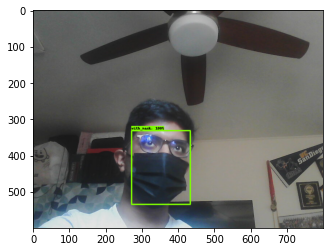

In [39]:
with tf.device("/gpu:0"):
    %matplotlib inline
    category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH, use_display_name=True)
    image = PImage.open("2021-05-03-143327.jpg")
    (im_width, im_height) = image.size
    image_np = np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    image_np_expanded = np.expand_dims(image_np, axis=0)
    print((image_np_expanded).shape)
    print(type(image_np_expanded))
    output = mask_detection_model(image_np_expanded)

    image_with_annotations = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_with_annotations,
        output["detection_boxes"][0].numpy(),
        output['detection_classes'][0].numpy().astype(np.int32),
        output['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.7
    )
    plt.figure()
    plt.imshow(image_with_annotations)

In [23]:
configs = config_util.get_configs_from_pipeline_file(DATA_PATH + "/pipeline.config")
detection_model = model_builder.build(configs['model'], is_training=False)

ckpt = tf.compat.v1.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(OUTPUT_PATH, "ckpt-31")).expect_partial()

In [24]:
@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [38]:
cap = cv2.VideoCapture(-1)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

category_index = label_map_util.create_category_index_from_labelmap(LABEL_MAP_PATH, use_display_name=True)

with tf.device("/gpu:0"):
    while True:
        ret, frame = cap.read()
        image_np = np.array(frame)
        # input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        # detections = detect_fn(input_tensor)
        detections = mask_detection_model(np.expand_dims(image_np, axis=0))
        num_detections = int(detections.pop('num_detections'))
        detections = {key:value[0,:num_detections].numpy() for key,value in detections.items()}
        detections['num_detections'] = num_detections
        detections["detection_classes"] = detections["detection_classes"].astype(np.int64)
        image_np_with_detections = image_np.copy()

        print(detections)

        viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections["detection_boxes"],#[0].numpy(),
            detections['detection_classes'],#[0].numpy().astype(np.int32),
            detections['detection_scores'],#[0].numpy(),
            category_index,
            use_normalized_coordinates=True,
            min_score_thresh = 0.75,
            agnostic_mode=False
        )

        cv2.imshow('frame', image_np_with_detections)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            cap.release()
            cv2.destroyAllWindows()
            break

ection_boxes': array([[0.35087237, 0.40706322, 0.7975813 , 0.68775874],
       [0.3538617 , 0.4370199 , 0.7802748 , 0.68311083]], dtype=float32), 'detection_multiclass_scores': array([[0.15854138, 0.52858   , 0.27888024, 0.03399828],
       [0.15854138, 0.52858   , 0.27888024, 0.03399828]], dtype=float32), 'detection_scores': array([0.52858   , 0.27888024], dtype=float32), 'detection_boxes': array([[0.38356057, 0.44796228, 0.7773228 , 0.67998123],
       [0.38356057, 0.44796228, 0.7773228 , 0.67998123]], dtype=float32), 'num_detections': 2}
{'detection_anchor_indices': array([], dtype=float32), 'raw_detection_scores': array([], shape=(0, 4), dtype=float32), 'detection_classes': array([], dtype=int64), 'raw_detection_boxes': array([], shape=(0, 4), dtype=float32), 'detection_multiclass_scores': array([], shape=(0, 4), dtype=float32), 'detection_scores': array([], dtype=float32), 'detection_boxes': array([], shape=(0, 4), dtype=float32), 'num_detections': 0}
{'detection_anchor_indices': 